# Проект для «Викишоп» с BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

**Рассмотрим два варианта проекта без BERT и с BERT**

# Подготовка

## Подключение библиотеки

In [104]:
# Уведомление о завершение работы определенного ячейка (очень пригодится для машинного обучения)
import jupyternotify
%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [105]:
# Подключаем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Для визуализации временных рядов
import plotly.graph_objects
import seaborn as sb
from scipy import stats as st
# Время обучения модели
import timeit
# Тренды и сезонность
from statsmodels.tsa.seasonal import seasonal_decompose
# Проверка на стационарность
from statsmodels.tsa.stattools import adfuller, kpss
# Проверка на дисперсию с помощью теста Андерсона-Дарлинга
from scipy.stats import anderson
# XGBRegressor
import xgboost as xgb

# Работа с текстами
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from lightgbm import LGBMRegressor
# Вызов библиотеки для отключения предупреждения
import warnings

# Разбиение на обучающую, валидационную и тестовую выборку
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, TimeSeriesSplit
# Применим кроссвалидацию для повышения качеств обучения



# Масштабируемость модели
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# Для машинного обучения разными способами:
# - Логическая регрессия
from sklearn.linear_model import LogisticRegression
# - Случайный лес
from sklearn.ensemble import RandomForestClassifier
# - Решающее дерево
from sklearn.tree import DecisionTreeClassifier
# - Модель на адекватность
from sklearn.dummy import DummyClassifier
# - Бустинг модель
from catboost import CatBoostClassifier

from sklearn.metrics import (
    # Точность модели
    accuracy_score,
    # Матрицы ошибок (для борьбы с дисбалансом)
    confusion_matrix, 
    # Полнота
    recall_score, 
    # Точность
    precision_score, 
    # F1-мера
    f1_score,
    # Метрика AUC-ROC
    roc_auc_score,
    roc_curve,
    # MSE
    mean_squared_error,
    mean_absolute_error,
    fbeta_score, 
    make_scorer
)

# Контроль выборки
from sklearn.utils import shuffle

# Для лематизации текстов
import re
from pymystem3 import Mystem
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

# Для машинного обучения - деление выборки на обучающие и валидационные
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# Просмотр все значений метрики
from sklearn.metrics import classification_report

from sklearn import svm
import joblib

Для машинного обучения с BERT

In [106]:
from torch import cuda

# Библиотеки для обучения с применением технологий BERT
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

## Загрузим данные

In [114]:
# Получаем датасет
try:
    # С локального файла
    try:
        # Сразу устанавливаем время как индексы
        df = pd.read_csv('toxic_comments.csv', index_col=[0], parse_dates=[0])
    except:
        df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=[0], parse_dates=[0])
except:
    print('Отсутствует датасет. Проверьте путь файла')

In [ ]:
df_bert = df.copy()

## Изучим данные

In [115]:
display(df.info(), df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


None

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Как и видим, что текст написан на английском языке

### Изучим балансы классов

Text(0.5, 0, 'Токсичные и позитивные комментарии')

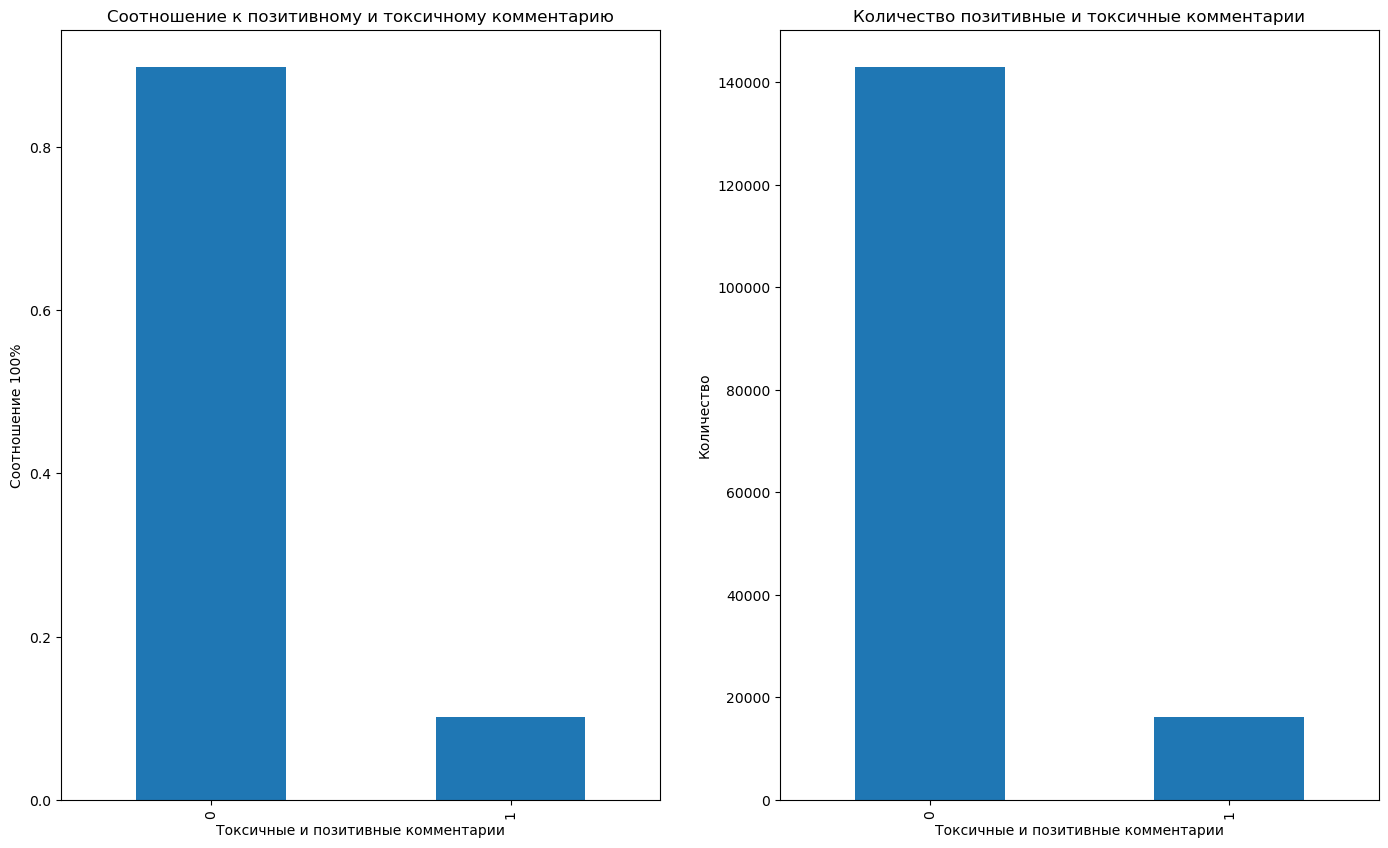

In [116]:
fig, axs = plt.subplots(1, 2, figsize=(17, 10))

df['toxic'].value_counts(normalize=True).plot(ax=axs[0], kind='bar')
axs[0].set_title('Соотношение к позитивному и токсичному комментарию')
axs[0].set_ylabel('Соотношение 100%')
axs[0].set_xlabel('Токсичные и позитивные комментарии')
        
df['toxic'].value_counts().plot(ax=axs[1], kind='bar')
axs[1].set_title('Количество позитивные и токсичные комментарии')
axs[1].set_ylabel('Количество')
axs[1].set_xlabel('Токсичные и позитивные комментарии')

Как и видим, что много токсичных комментариев нежели позитивных. Дальше идем

# Машинное обучение с BERT

In [117]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sun Apr 16 21:17:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |   4112MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [118]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using CPU')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla T4 GPUs


In [120]:
display(df_bert.head(), df_bert.tail())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


,text,toxic
159446,""":::::And for the second time of asking, when ...",0
159447,You should be ashamed of yourself \n\nThat is ...,0
159448,"Spitzer \n\nUmm, theres no actual article for ...",0
159449,And it looks like it was actually you who put ...,0
159450,"""\nAnd ... I really don't think you understand...",0


## Предобработка данных

Мы начнем с определения нескольких ключевых переменных, которые будут использоваться позже на этапе обучения/тонкой настройки. 

Затем создадим класс CustomDataset, который определяет, как текст предварительно обрабатывается перед отправкой в нейронную сеть. 

Также определим загрузчик данных, который будет пакетами передавать данные в нейронную сеть для подходящего обучения и обработки. 

Dataset и Dataloader - это конструкции библиотеки PyTorch для определения и управления предварительной обработкой данных и их передачей в нейронную сеть. 

Для дальнейшего ознакомления с Dataset и Dataloader нам следует ознакомиться с документами на [PyTorch](https://pytorch.org/docs/stable/data.html)

### *CustomDataset* Dataset Class
- Этот класс определен для приема `tokenizer`, `dataframe` и `max_length` в качестве входных данных и генерации токенизированных выходных данных и тегов, которые используются моделью BERT для обучения.
- Мы используем токенизатор BERT для токенизации данных в столбце `comment_text` фрейма данных.
- Токенизатор использует метод `encode_plus` для выполнения токенизации и генерации необходимых выходных данных, а именно: `ids`, `attention_mask`, `token_type_ids`
---
- *Это первое различие между distilbert и bert, где токенизатор генерирует token_type_ids в случае Bert*
---
- Чтобы подробнее ознакомиться с токенизатором, [обратитесь к этому документу](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer )
- "targest" - это список категорий, помеченных как "0" или "1" во фрейме данных.
- Класс *CustomDataset* используется для создания 2 наборов данных, для обучения и для проверки.
- *Обучающий набор данных * используется для точной настройки модели: **80% исходных данных**
- *Набор данных для проверки* используется для оценки производительности модели. Модель не видела этих данных во время обучения.

### Dataloader
- Dataloader используется для создания обучающего и валидационного загрузчика данных, который загружает данные в нейронную сеть определенным образом. Это необходимо, потому что все данные из набора данных не могут быть загружены в память сразу, следовательно, необходимо контролировать объем данных, загружаемых в память и затем передаваемых в нейронную сеть.
- Это управление достигается с помощью таких параметров, как `batch_size` и `max_len`.
- Загрузчики данных обучения и валидации используются в части обучения и валидации потока соответственно

In [149]:
# Разделы конфигурации

# Определение некоторых ключевых переменных, которые будут использоваться позже в ходе обучения
MAX_LEN = 200
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 2
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [150]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.toxic
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

##  Деление на обучающей и тестовой выборки

In [151]:
train_size = 0.8

train_dataset=df_bert.sample(frac=train_size,random_state=200)
test_dataset=df_bert.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

In [152]:
print(f"Объем полного датасета: {df_bert.shape}")
print(f"Размер обучающей выборки: {train_dataset.shape}")
print(f"Размер тестовой выборки: {test_dataset.shape}")

Объем полного датасета: (159292, 2)
Размер обучающей выборки: (127434, 2)
Размер тестовой выборки: (31858, 2)


In [153]:
training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN)

In [154]:
# Устанавливаем параметры
train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

test_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': True,
    'num_workers': 0
}

In [155]:
training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

## Создание нейронной сети для тонкой настройки

### Нейронная сеть
- Мы будем создавать нейронную сеть с `BERTClass`.
- У этой сети будет `Bert` модель. Далее следуют `Droput` и `Linear Layer`. Они добавлены с целью **Упорядочивания** и **Regulariaztion** соответственно.
- В прямом цикле есть 2 выходных данных из слоя `Bert Model`.
- Второй вывод `output_1` или называемый `объединенным выводом` передается в `Drop Out layer`, а последующий вывод передается в `Linear layer`.
- Обратите внимание, что количество измерений для "линейного слоя" равно **6** потому что это общее количество категорий, по которым мы хотим классифицировать нашу модель.
- Данные будут переданы в `BertClass`, как определено в наборе данных.
- Выходные данные конечного уровня - это то, что будет использоваться для расчета потерь и определения точности прогнозирования моделей.
- Мы инициируем экземпляр сети под названием `model`. Этот экземпляр будет использоваться для обучения, а затем для сохранения окончательной обученной модели для последующего вывода.
 
### Функция потерь и оптимизатор
- Потеря определяется в следующей ячейке как `loss_fn`.
- Как определено выше, используемая функция потерь будет представлять собой комбинацию двоичной перекрестной энтропии, которая реализована как [BCELogits Loss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss ) в PyTorch
- `Optimizer` определен в следующей ячейке.
- `Optimizer` используется для обновления весов нейронной сети для повышения ее производительности.
 
### На будущее
- Вы можете обратиться к моим [Pytorch Tutorials](https://github.com/abhimishra91/pytorch-tutorials ), чтобы получить представление о функции потерь и оптимизаторе.
- [Документация Pytorch для функции потерь](https://pytorch.org/docs/stable/nn.html#loss-functions )
- [Документация Pytorch для оптимизатора](https://pytorch.org/docs/stable/optim.html )
- Обратитесь к ссылкам, приведенным в верхней части блокнота, чтобы узнать больше о `BertModel`. 

In [156]:
# Создаем индивидуальную модель, добавляя отсев и плотный слой поверх distil bert, чтобы получить конечный результат для модели
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 1)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [157]:
# Функция потери
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [158]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

### Точная настройка модели

После всех усилий по загрузке и подготовке данных и наборов данных, созданию модели и определению ее потерь и оптимизатора. Вероятно, это самый простой шаг в процессе.

Здесь мы определяем обучающую функцию, которая обучает модель на основе обучающего набора данных, созданного выше, заданное количество раз (ЭПОХА), эпоха определяет, сколько раз полные данные будут передаваться по сети.

Для точной настройки нейронной сети в этой функции происходят следующие события:
- Загрузчик данных передает данные в модель в зависимости от размера пакета.
- Последующие выходные данные модели и фактическая категория сравниваются для расчета потерь.
- Значение потерь используется для оптимизации весов нейронов в сети.
- После каждых 5000 шагов в консоли выводится значение потерь.

Как вы можете видеть, всего за 1 эпоху на последнем шаге модель работала с незначительными потерями в 0,022, т.е. выходной сигнал сети чрезвычайно близок к фактическому выходному сигналу.

In [159]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)
        
        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

## Обучение

In [160]:
%%notify -m 'BERT'
%%time

for epoch in range(EPOCHS):
    train(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2352: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Loss:  0.733110785484314
Epoch: 0, Loss:  0.39082932472229004
Epoch: 0, Loss:  0.005783333443105221
Epoch: 0, Loss:  0.09499093890190125
Epoch: 1, Loss:  0.01712093874812126
Epoch: 1, Loss:  0.00039071450009942055
Epoch: 1, Loss:  0.322614461183548
Epoch: 1, Loss:  0.02024523913860321
CPU times: user 1h 41min 16s, sys: 53min 13s, total: 2h 34min 29s
Wall time: 2h 35min 39s


<IPython.core.display.Javascript object>

## Проверим на F1-метрику

На этапе проверки мы передаем невидимые данные (тестовый набор данных) в модель. Этот шаг определяет, насколько хорошо модель работает с невидимыми данными.

Эти невидимые данные составляют 20% от `train.csv`, которые были отделены на этапе создания набора данных.
На этапе проверки веса модели не обновляются. Только конечный результат сравнивается с фактическим значением. Это сравнение затем используется для расчета точности модели.

Как определено выше, чтобы получить оценку производительности наших моделей, мы используем следующие показатели.
- Accuracy Score
- F1-score
- F1-score MACRO
- F1-score MICRO

Мы получаем потрясающие результаты по всем этим 3 категориям, просто обучая модель в течение 1 эпохи.

In [161]:
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [162]:
%%notify -m 'PREDCIT BERT'
%%time

for epoch in range(EPOCHS):
    outputs, targets = validation(epoch)
    outputs = np.array(outputs) >= 0.5
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score = metrics.f1_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score = {f1_score}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9693954422750958
F1 Score = 0.8411275867687795
F1 Score (Micro) = 0.9693954422750958
F1 Score (Macro) = 0.9120971649260977


/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2352: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Accuracy Score = 0.9693954422750958
F1 Score = 0.8411275867687795
F1 Score (Micro) = 0.9693954422750958
F1 Score (Macro) = 0.9120971649260977
CPU times: user 14min 20s, sys: 1.26 s, total: 14min 21s
Wall time: 14min 24s


<IPython.core.display.Javascript object>

# Выводы

F1-SCORE у модели BERT с помощью библиотеки PyTorch получилось очень неплохой, аж **0,841** значений. Однако у этой модели есть основные недостатки, от которых мы избегаем: время обучения и предсказаня. Время обучения занимает аж **1,5 часа** в среднем. А время предсказания меньше **1\4 часа**.

Если нам поставлена задача создать модель, которая дает высокие результаты, тогда нам следует применять глубокие обучения, в противном случае можно применять легкие модели и быстро получить результаты для предварительного прогнозирования.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны